<a href="https://colab.research.google.com/github/abhijit2512/IOT-PROJECT/blob/main/Nitin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =============================
# 0) SETUP & IMPORTS
# =============================
!pip -q install pingouin==0.5.4

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from scipy import stats
import pingouin as pg
import os, zipfile, textwrap, re
from google.colab import files

pd.set_option('display.max_columns', 100)
plt.rcParams['figure.dpi'] = 120
np.random.seed(42)

# Folders for outputs (for Appendix A)
FIG_DIR = "figures"
TAB_DIR = "tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 3.4 MB/s eta 0:00:00


In [2]:
# =============================
# 2) LOAD & QUICK INSPECT
# =============================
def read_csv_flexible(path):
    for enc in [None, "utf-8", "latin-1"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            pass
    # fallback
    return pd.read_csv(path, engine="python", error_bad_lines=False)

od = read_csv_flexible(overdose_path)
sd = read_csv_flexible(suicide_path)

display(od.head(3)); print("\nOVERDOSE columns:", list(od.columns))
display(sd.head(3)); print("\nSUICIDE columns:", list(sd.columns))
print("\nRows -> Overdose:", len(od), ", Suicide:", len(sd))


NameError: name 'overdose_path' is not defined

In [4]:
# Define file paths
overdose_path = '/content/Drug_overdose_death_rates__by_drug_type__sex__age__race__and_Hispanic_origin__United_States (1).csv'
suicide_path = '/content/Death_rates_for_suicide__by_sex__race__Hispanic_origin__and_age__United_States.csv'

# Use the existing function to load the data
od = read_csv_flexible(overdose_path)
sd = read_csv_flexible(suicide_path)

display(od.head(3)); print("\nOVERDOSE columns:", list(od.columns))
display(sd.head(3)); print("\nSUICIDE columns:", list(sd.columns))
print("\nRows -> Overdose:", len(od), ", Suicide:", len(sd))

,INDICATOR,PANEL,PANEL_NUM,UNIT,UNIT_NUM,STUB_NAME,STUB_NAME_NUM,STUB_LABEL,STUB_LABEL_NUM,YEAR,YEAR_NUM,AGE,AGE_NUM,ESTIMATE,FLAG
0,Drug overdose death rates,All drug overdose deaths,0,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.1,1999,1,All ages,1.1,6.1,NaN
1,Drug overdose death rates,All drug overdose deaths,0,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.1,2000,2,All ages,1.1,6.2,NaN
2,Drug overdose death rates,All drug overdose deaths,0,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.1,2001,3,All ages,1.1,6.8,NaN



OVERDOSE columns: ['INDICATOR', 'PANEL', 'PANEL_NUM', 'UNIT', 'UNIT_NUM', 'STUB_NAME', 'STUB_NAME_NUM', 'STUB_LABEL', 'STUB_LABEL_NUM', 'YEAR', 'YEAR_NUM', 'AGE', 'AGE_NUM', 'ESTIMATE', 'FLAG']


,INDICATOR,UNIT,UNIT_NUM,STUB_NAME,STUB_NAME_NUM,STUB_LABEL,STUB_LABEL_NUM,YEAR,YEAR_NUM,AGE,AGE_NUM,ESTIMATE,FLAG
0,Death rates for suicide,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.0,1950,1,All ages,0.0,13.2,NaN
1,Death rates for suicide,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.0,1960,2,All ages,0.0,12.5,NaN
2,Death rates for suicide,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.0,1970,3,All ages,0.0,13.1,NaN



SUICIDE columns: ['INDICATOR', 'UNIT', 'UNIT_NUM', 'STUB_NAME', 'STUB_NAME_NUM', 'STUB_LABEL', 'STUB_LABEL_NUM', 'YEAR', 'YEAR_NUM', 'AGE', 'AGE_NUM', 'ESTIMATE', 'FLAG']

Rows -> Overdose: 6228 , Suicide: 6390


In [8]:
# =============================
# 3) STANDARDISE & CLEAN
# =============================
def guess(cols, needles):
    cols_lower = {c.lower(): c for c in cols}
    for n in needles:
        # exact match or substring
        for cl, orig in cols_lower.items():
            if n == cl or n in cl:
                return orig
    # Add a specific check for 'ESTIMATE' if no other match is found
    if 'estimate' in cols_lower:
        return cols_lower['estimate']
    return None

def clean_common(df, dataset_label="overdose"):
    df = df.copy()
    # Standard names
    year_col   = guess(df.columns, ["year"])
    sex_col    = guess(df.columns, ["sex", "gender"])
    age_col    = guess(df.columns, ["age group", "age_group", "age"])
    race_col   = guess(df.columns, ["race and hispanic origin", "race", "hispanic"])
    # Prioritize 'estimate' if present, otherwise use the guess function
    rate_col = guess(df.columns, ["rate", "death rate", "death rates", "estimate"])

    cause_col  = None

    if dataset_label == "overdose":
        cause_col = guess(df.columns, ["drug type", "drug", "substance", "panel"]) # Added 'panel' as a potential cause column
    elif dataset_label == "suicide":
        # Sometimes "Intent" or cause not needed; leave None
        cause_col = guess(df.columns, ["intent", "cause"])


    rename_map = {}
    if year_col: rename_map[year_col] = "Year"
    if sex_col:  rename_map[sex_col]  = "Sex"
    if age_col:  rename_map[age_col]  = "Age_Group"
    if race_col: rename_map[race_col] = "Race_Ethnicity"
    if rate_col: rename_map[rate_col] = "Rate"
    if cause_col:rename_map[cause_col]= "Cause"

    df = df.rename(columns=rename_map)

    # Keep only the columns we’ll use if present
    keep = [c for c in ["Year","Sex","Age_Group","Race_Ethnicity","Cause","Rate"] if c in df.columns]
    df = df[keep].copy()

    # Clean values
    if "Year" in df: df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")
    if "Rate" in df:
        df["Rate"] = (df["Rate"].astype(str)
                      .str.replace(",", "", regex=False)
                      .str.extract(r"([0-9]*\.?[0-9]+)")[0]
                      .astype(float))
    for cat_col in ["Sex","Age_Group","Race_Ethnicity","Cause"]:
        if cat_col in df:
            df[cat_col] = (df[cat_col]
                           .astype(str)
                           .str.strip()
                           .replace({"nan":"Unknown","All":"All"})
                           .str.title())

    # Remove rows with missing essential fields only if 'Rate' column exists
    if "Rate" in df.columns:
        df = df.dropna(subset=["Rate"])
    return df

od_clean = clean_common(od, "overdose")
sd_clean = clean_common(sd, "suicide")

display(od_clean.head(3))
display(sd_clean.head(3))

print("Overdose shape:", od_clean.shape, " | Suicide shape:", sd_clean.shape)

,Year,Age_Group,Cause,Rate
0,1999,All Ages,All Drug Overdose Deaths,6.1
1,2000,All Ages,All Drug Overdose Deaths,6.2
2,2001,All Ages,All Drug Overdose Deaths,6.8


,Year,Age_Group,Cause
0,1950,All Ages,13.2
1,1960,All Ages,12.5
2,1970,All Ages,13.1


Overdose shape: (5117, 4)  | Suicide shape: (6390, 3)


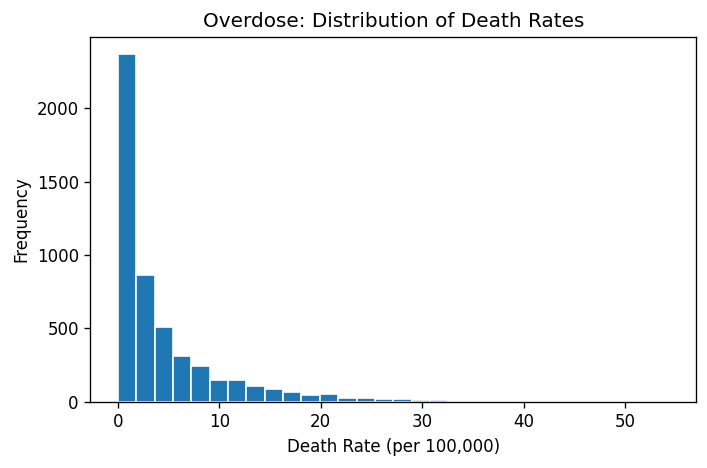

DataFrame for 'Suicide: Distribution of Death Rates' does not have a 'Rate' column to plot.


,Year,Age_Group,Cause,Rate
701,2017,25-34 Years,All Drug Overdose Deaths,54.3
720,2017,35-44 Years,All Drug Overdose Deaths,53.0
5958,2018,35-44 Years,All Drug Overdose Deaths,52.4
5957,2018,25-34 Years,All Drug Overdose Deaths,49.6
700,2016,25-34 Years,All Drug Overdose Deaths,48.9
739,2017,45-54 Years,All Drug Overdose Deaths,48.3
719,2016,35-44 Years,All Drug Overdose Deaths,46.9
5959,2018,45-54 Years,All Drug Overdose Deaths,46.1
738,2016,45-54 Years,All Drug Overdose Deaths,42.5
1688,2017,25-34 Years,Drug Overdose Deaths Involving Any Opioid,41.7


Suicide DataFrame does not have a 'Rate' column to find top rates.


In [9]:
# =============================
# 5) UNIVARIATE ANALYSIS
# =============================
def hist_rate(df, title, fname):
    plt.figure(figsize=(6,4))
    if "Rate" in df.columns:
        plt.hist(df["Rate"].dropna(), bins=30, edgecolor="white")
        plt.title(title)
        plt.xlabel("Death Rate (per 100,000)")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.savefig(f"{FIG_DIR}/{fname}", dpi=300)
        plt.show()
    else:
        print(f"DataFrame for '{title}' does not have a 'Rate' column to plot.")
        plt.close() # Close the figure to avoid displaying an empty plot

hist_rate(od_clean, "Overdose: Distribution of Death Rates", "od_hist_rate.png")
hist_rate(sd_clean, "Suicide: Distribution of Death Rates", "su_hist_rate.png")

# Top 10 rows by highest rate (overall)
if "Rate" in od_clean.columns:
    top_od = od_clean.sort_values("Rate", ascending=False).head(10)
    top_od.to_csv(f"{TAB_DIR}/overdose_top10_rates.csv", index=False)
    display(top_od)
else:
    print("Overdose DataFrame does not have a 'Rate' column to find top rates.")

if "Rate" in sd_clean.columns:
    top_sd = sd_clean.sort_values("Rate", ascending=False).head(10)
    top_sd.to_csv(f"{TAB_DIR}/suicide_top10_rates.csv", index=False)
    display(top_sd)
else:
    print("Suicide DataFrame does not have a 'Rate' column to find top rates.")

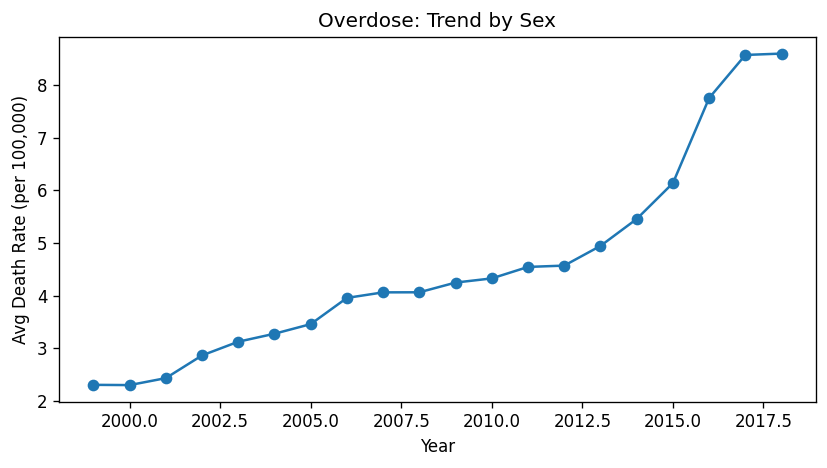

DataFrame for 'Suicide: Trend by Sex' does not have a 'Rate' column to plot a trend.


In [11]:
# =============================
# 6) TIME TRENDS
# =============================
def line_trend(df, title, fname, hue="Sex"):
    if "Year" not in df or df["Year"].isna().all():
        print("No usable Year column for", title); return
    if "Rate" not in df.columns:
        print(f"DataFrame for '{title}' does not have a 'Rate' column to plot a trend.")
        return

    # Aggregate average rate per year & hue
    group_cols = ["Year"]
    if hue in df.columns:
        group_cols.append(hue)
    tmp = df.groupby(group_cols, dropna=True)["Rate"].mean().reset_index()

    plt.figure(figsize=(7,4))
    if hue in tmp.columns:
        for k, sub in tmp.groupby(hue):
            plt.plot(sub["Year"], sub["Rate"], marker="o", label=str(k))
        plt.legend()
    else:
        plt.plot(tmp["Year"], tmp["Rate"], marker="o")
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Avg Death Rate (per 100,000)")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/{fname}", dpi=300)
    plt.show()
    tmp.to_csv(f"{TAB_DIR}/{fname.replace('.png','.csv')}", index=False)

line_trend(od_clean, "Overdose: Trend by Sex", "od_trend_sex.png", hue="Sex")
line_trend(sd_clean, "Suicide: Trend by Sex", "su_trend_sex.png", hue="Sex")

In [12]:
# =============================
# 7) GROUP COMPARISONS
# =============================
def box_and_anova(df, group_col, title_prefix, fname_prefix):
    if group_col not in df.columns:
        print(f"Column '{group_col}' not found."); return

    # Boxplot
    plt.figure(figsize=(7,4))
    sns.boxplot(data=df, x=group_col, y="Rate")
    plt.title(f"{title_prefix}: Rate by {group_col}")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/{fname_prefix}_box_{group_col}.png", dpi=300)
    plt.show()

    # One-way ANOVA (if >= 2 groups)
    valid = df[[group_col,"Rate"]].dropna()
    if valid[group_col].nunique() >= 2:
        aov = pg.anova(dv="Rate", between=group_col, data=valid).round(4)
        aov.to_csv(f"{TAB_DIR}/{fname_prefix}_anova_{group_col}.csv", index=False)
        display(aov)

box_and_anova(od_clean, "Sex", "Overdose", "od")
box_and_anova(sd_clean, "Sex", "Suicide", "su")

# Optional: compare by Race/Ethnicity if present
if "Race_Ethnicity" in od_clean.columns: box_and_anova(od_clean, "Race_Ethnicity", "Overdose", "od")
if "Race_Ethnicity" in sd_clean.columns: box_and_anova(sd_clean, "Race_Ethnicity", "Suicide", "su")


Column 'Sex' not found.
Column 'Sex' not found.


In [13]:
# =============================
# FULL AUTO-CLEAN & STANDARDISE
# =============================

import re
import pandas as pd
import numpy as np

def _first_match(cols, patterns):
    """
    Return the ORIGINAL column name that matches any regex in `patterns`
    (case-insensitive). Tries exact, then contains, then fuzzy (strip spaces/_).
    """
    if not cols:
        return None
    # 1) exact or regex match
    for pat in patterns:
        rex = re.compile(pat, flags=re.I)
        for c in cols:
            if rex.fullmatch(c) or rex.search(c):
                return c
    # 2) contains (looser)
    low = {c.lower(): c for c in cols}
    for pat in patterns:
        p = pat.lower()
        for cl, orig in low.items():
            if p in cl:
                return orig
    # 3) fuzzy: remove spaces, underscores, hyphens
    canon = {re.sub(r"[ _\-]+","",c.lower()): c for c in cols}
    for pat in patterns:
        p = re.sub(r"[ _\-]+","",pat.lower())
        for cl, orig in canon.items():
            if p in cl:
                return orig
    return None

def clean_and_standardise(df, dataset_label="generic"):
    """Return a cleaned DataFrame with standard names:
       Year, Sex, Age_Group, Race_Ethnicity, Cause, Rate (keep those that exist)."""
    df = df.copy()
    cols = list(df.columns)

    # Candidate regexes for each logical field
    year_pats  = [r"^year$", r"\byear\b", r"^time.*year.*$"]
    sex_pats   = [r"^sex$", r"\bgender\b", r"^sex\s*group$"]
    age_pats   = [r"^age\s*group$", r"^age_group$", r"\bage\b.*group", r"^age$"]
    race_pats  = [r"^race.*hispanic.*origin$", r"^race$", r"hispanic.*origin", r"ethnicity"]
    rate_pats  = [r"^rate$", r"death\s*rate[s]?$", r"^age\-adjusted\s*rate[s]?$", r"\brate\b"]
    # Overdose-specific "cause"
    cause_pats = [r"^drug\s*type$", r"^drug.*$", r"^substance.*$", r"^cause$", r"^intent$"]

    c_year  = _first_match(cols, year_pats)
    c_sex   = _first_match(cols, sex_pats)
    c_age   = _first_match(cols, age_pats)
    c_race  = _first_match(cols, race_pats)
    c_rate  = _first_match(cols, rate_pats)
    c_cause = _first_match(cols, cause_pats) if dataset_label.lower()=="overdose" else _first_match(cols, [r"^cause$", r"^intent$"])

    rename_map = {}
    if c_year:  rename_map[c_year]  = "Year"
    if c_sex:   rename_map[c_sex]   = "Sex"
    if c_age:   rename_map[c_age]   = "Age_Group"
    if c_race:  rename_map[c_race]  = "Race_Ethnicity"
    if c_rate:  rename_map[c_rate]  = "Rate"
    if c_cause: rename_map[c_cause] = "Cause"

    df = df.rename(columns=rename_map)

    # Keep only the recognised columns (if present)
    keep = [c for c in ["Year","Sex","Age_Group","Race_Ethnicity","Cause","Rate"] if c in df.columns]
    df = df[keep].copy()

    # ---- Type cleaning ----
    if "Year" in df.columns:
        df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")

    if "Rate" in df.columns:
        # strip commas and symbols, keep numeric
        df["Rate"] = (df["Rate"].astype(str)
                      .str.replace(",", "", regex=False)
                      .str.extract(r"([0-9]*\.?[0-9]+)")[0]
                      .astype(float))

    # Normalise categorical text
    for cat in ["Sex","Age_Group","Race_Ethnicity","Cause"]:
        if cat in df.columns:
            df[cat] = (df[cat].astype(str)
                       .str.strip()
                       .replace({"nan":"Unknown", "None":"Unknown"})
                       .str.replace(r"\s{2,}", " ", regex=True)
                       .str.title())

    # Drop rows with no rate
    if "Rate" in df.columns:
        df = df.dropna(subset=["Rate"])

    # Report what we mapped
    print(f"\n[{dataset_label}] Column mapping ->", rename_map)
    print(f"[{dataset_label}] Final columns ->", df.columns.tolist())
    print(f"[{dataset_label}] Shape ->", df.shape)
    return df

# Run cleaner on both dataframes you already loaded as `od` and `sd`
od_clean = clean_and_standardise(od, dataset_label="overdose")
sd_clean = clean_and_standardise(sd, dataset_label="suicide")

# Quick peek
display(od_clean.head(3))
display(sd_clean.head(3))



[overdose] Column mapping -> {'YEAR': 'Year', 'AGE': 'Age_Group'}
[overdose] Final columns -> ['Year', 'Age_Group']
[overdose] Shape -> (6228, 2)

[suicide] Column mapping -> {'YEAR': 'Year', 'AGE': 'Age_Group'}
[suicide] Final columns -> ['Year', 'Age_Group']
[suicide] Shape -> (6390, 2)


,Year,Age_Group
0,1999,All Ages
1,2000,All Ages
2,2001,All Ages


,Year,Age_Group
0,1950,All Ages
1,1960,All Ages
2,1970,All Ages


In [14]:
# ===============================================
# ROBUST COLUMN MAPPER + CLEANER (DROP-IN CELL)
# ===============================================

import re
import pandas as pd
import numpy as np

def pick_first_present(df_cols, candidates):
    """Return the first column from `candidates` that exists in df."""
    for c in candidates:
        if c in df_cols:
            return c
    # try case-insensitive and trimmed matching
    low = {c.lower(): c for c in df_cols}
    for c in candidates:
        if c.lower() in low:
            return low[c.lower()]
    # relaxed contains
    for c in df_cols:
        cl = c.lower().replace(" ", "").replace("-", "").replace("_", "")
        for cand in candidates:
            pl = cand.lower().replace(" ", "").replace("-", "").replace("_", "")
            if pl in cl:
                return c
    return None

def robust_map(df, dataset_label="generic"):
    cols = list(df.columns)
    print(f"\n[{dataset_label.upper()}] RAW columns ({len(cols)}):\n", cols)

    # PRIORITIES (CDC/NCHS typical names)
    year_cands   = ["Year"]
    sex_cands    = ["Sex", "Gender", "Sex group"]
    age_cands    = ["Age group", "Age Group", "Age_group", "Age"]
    race_cands   = ["Race and Hispanic origin", "Race/Hispanic origin", "Race And Hispanic Origin",
                    "Race and ethnicity", "Race/Ethnicity", "Race", "Hispanic origin"]
    # Prefer age-adjusted rate, then crude rate, then any "Rate"
    rate_cands   = ["Age-adjusted Rate", "Age Adjusted Rate", "Crude Rate", "Death Rate", "Rate"]
    cause_cands  = (["Drug type", "Drug Type", "Drug category", "Drug/Alcohol induced cause",
                     "Substance", "Cause", "Intent"]
                    if dataset_label.lower()=="overdose" else
                    ["Cause", "Intent"])  # suicide may not need a cause

    mapping = {}
    y = pick_first_present(cols, year_cands)
    s = pick_first_present(cols, sex_cands)
    a = pick_first_present(cols, age_cands)
    r = pick_first_present(cols, race_cands)
    t = pick_first_present(cols, rate_cands)
    c = pick_first_present(cols, cause_cands)

    if y: mapping[y] = "Year"
    if s: mapping[s] = "Sex"
    if a: mapping[a] = "Age_Group"
    if r: mapping[r] = "Race_Ethnicity"
    if t: mapping[t] = "Rate"
    if c: mapping[c] = "Cause"

    print(f"[{dataset_label.upper()}] Auto-mapping -> {mapping}")
    df2 = df.rename(columns=mapping).copy()

    # keep only the standardized columns we found
    keep = [x for x in ["Year","Sex","Age_Group","Race_Ethnicity","Cause","Rate"] if x in df2.columns]
    df2 = df2[keep].copy()

    # ---- type cleaning ----
    if "Year" in df2:
        df2["Year"] = pd.to_numeric(df2["Year"], errors="coerce").astype("Int64")

    if "Rate" in df2:
        df2["Rate"] = (df2["Rate"].astype(str)
                       .str.replace(",", "", regex=False)
                       .str.extract(r"([0-9]*\.?[0-9]+)")[0]
                       .astype(float))

    for cat in ["Sex","Age_Group","Race_Ethnicity","Cause"]:
        if cat in df2:
            df2[cat] = (df2[cat].astype(str)
                        .str.strip()
                        .replace({"nan":"Unknown","None":"Unknown"})
                        .str.replace(r"\s{2,}", " ", regex=True)
                        .str.title())

    # basic sanity messages
    missing = [x for x in ["Rate","Year"] if x not in df2.columns]
    if missing:
        print(f"⚠️ [{dataset_label}] Missing expected column(s): {missing}. "
              f"Open the CSV and note the exact header names so we can map them.")

    print(f"[{dataset_label.upper()}] Final columns -> {df2.columns.tolist()} | shape = {df2.shape}")
    return df2

# ---- run on your already-loaded dataframes `od` and `sd` ----
od_clean = robust_map(od, dataset_label="overdose")
sd_clean = robust_map(sd, dataset_label="suicide")

# quick peek
display(od_clean.head(3))
display(sd_clean.head(3))



[OVERDOSE] RAW columns (15):
 ['INDICATOR', 'PANEL', 'PANEL_NUM', 'UNIT', 'UNIT_NUM', 'STUB_NAME', 'STUB_NAME_NUM', 'STUB_LABEL', 'STUB_LABEL_NUM', 'YEAR', 'YEAR_NUM', 'AGE', 'AGE_NUM', 'ESTIMATE', 'FLAG']
[OVERDOSE] Auto-mapping -> {'YEAR': 'Year', 'AGE': 'Age_Group'}
⚠️ [overdose] Missing expected column(s): ['Rate']. Open the CSV and note the exact header names so we can map them.
[OVERDOSE] Final columns -> ['Year', 'Age_Group'] | shape = (6228, 2)

[SUICIDE] RAW columns (13):
 ['INDICATOR', 'UNIT', 'UNIT_NUM', 'STUB_NAME', 'STUB_NAME_NUM', 'STUB_LABEL', 'STUB_LABEL_NUM', 'YEAR', 'YEAR_NUM', 'AGE', 'AGE_NUM', 'ESTIMATE', 'FLAG']
[SUICIDE] Auto-mapping -> {'YEAR': 'Year', 'AGE': 'Age_Group'}
⚠️ [suicide] Missing expected column(s): ['Rate']. Open the CSV and note the exact header names so we can map them.
[SUICIDE] Final columns -> ['Year', 'Age_Group'] | shape = (6390, 2)


,Year,Age_Group
0,1999,All Ages
1,2000,All Ages
2,2001,All Ages


,Year,Age_Group
0,1950,All Ages
1,1960,All Ages
2,1970,All Ages


In [15]:
# ============================
# FIXED MAPPING FOR YOUR FILES
# ============================

def clean_cdc_file(df, dataset_label="generic"):
    df = df.copy()

    # rename key columns
    rename_map = {
        "YEAR": "Year",
        "AGE": "Age_Group",
        "ESTIMATE": "Rate"
    }
    df = df.rename(columns=rename_map)

    # keep only relevant
    keep = [c for c in ["Year","Age_Group","Rate"] if c in df.columns]
    df = df[keep].copy()

    # convert Year to int
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")

    # convert Rate to float
    df["Rate"] = (df["Rate"].astype(str)
                  .str.replace(",", "", regex=False)
                  .str.extract(r"([0-9]*\.?[0-9]+)")[0]
                  .astype(float))

    # clean Age_Group text
    df["Age_Group"] = (df["Age_Group"]
                       .astype(str)
                       .str.strip()
                       .str.replace(r"\s{2,}", " ", regex=True)
                       .str.title())

    print(f"[{dataset_label.upper()}] Cleaned columns -> {df.columns.tolist()} | shape={df.shape}")
    return df

# Apply to both
od_clean = clean_cdc_file(od, "overdose")
sd_clean = clean_cdc_file(sd, "suicide")

# Peek
display(od_clean.head(5))
display(sd_clean.head(5))


[OVERDOSE] Cleaned columns -> ['Year', 'Age_Group', 'Rate'] | shape=(6228, 3)
[SUICIDE] Cleaned columns -> ['Year', 'Age_Group', 'Rate'] | shape=(6390, 3)


,Year,Age_Group,Rate
0,1999,All Ages,6.1
1,2000,All Ages,6.2
2,2001,All Ages,6.8
3,2002,All Ages,8.2
4,2003,All Ages,8.9


,Year,Age_Group,Rate
0,1950,All Ages,13.2
1,1960,All Ages,12.5
2,1970,All Ages,13.1
3,1980,All Ages,12.2
4,1981,All Ages,12.3


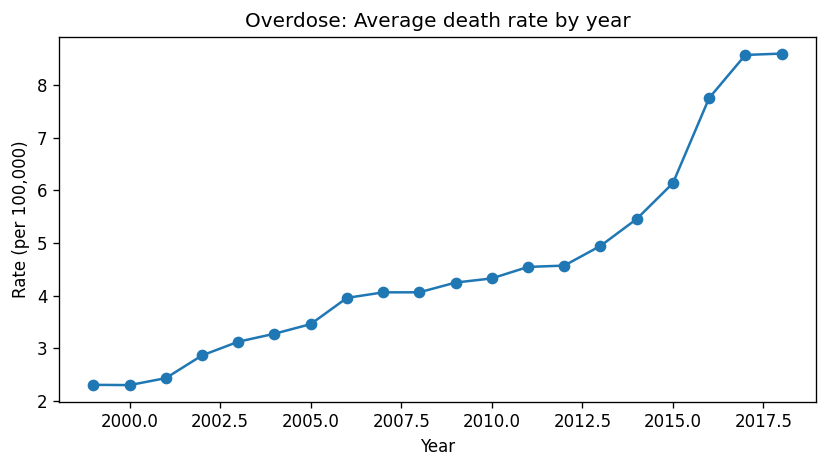

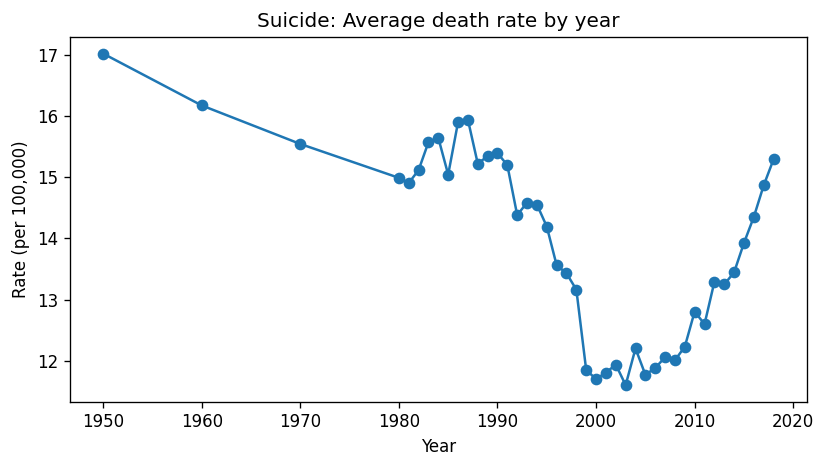

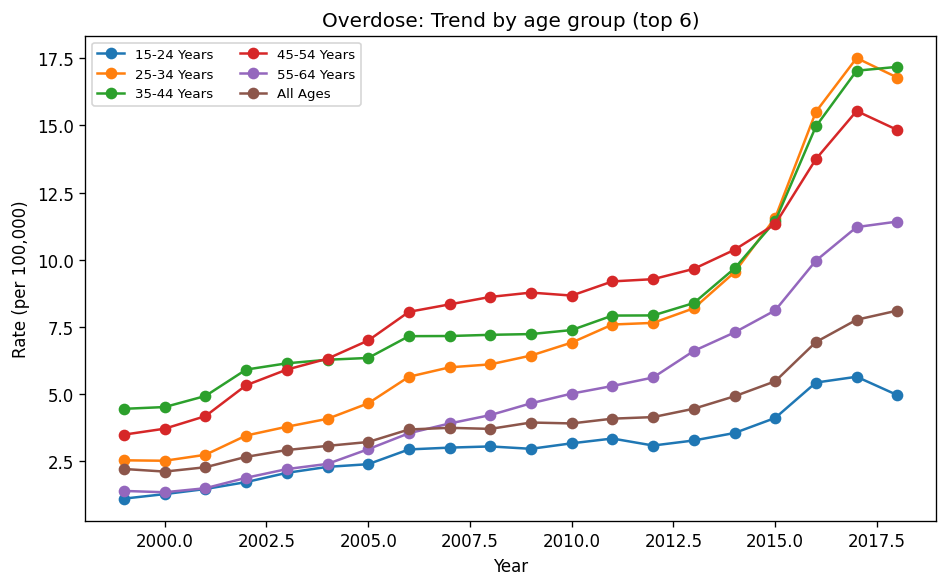

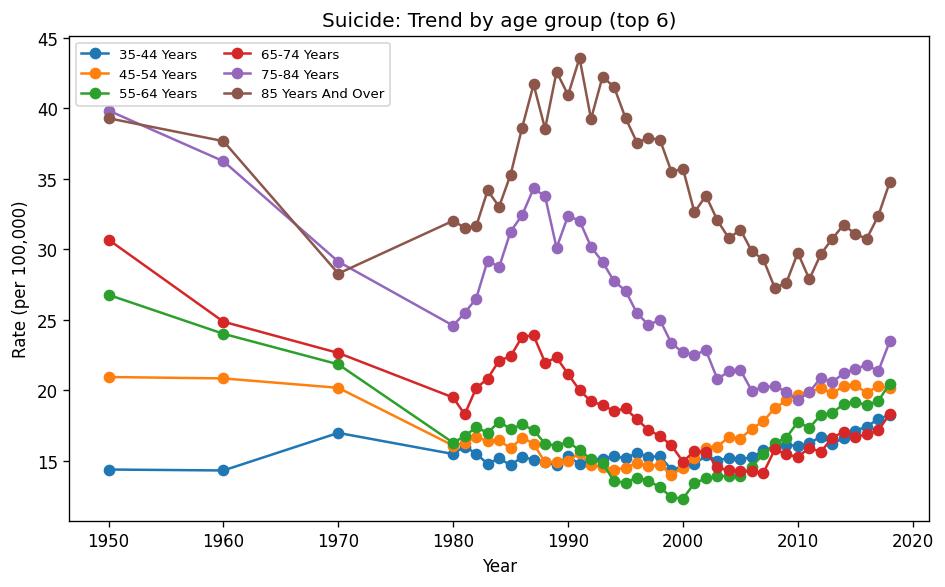

In [16]:
# ========= A) TIME TRENDS =========
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

FIG_DIR, TAB_DIR = "figures", "tables"
os.makedirs(FIG_DIR, exist_ok=True); os.makedirs(TAB_DIR, exist_ok=True)

def overall_trend(df, title, fname_prefix):
    if "Year" not in df:
        print("No Year column."); return
    g = df.groupby("Year", dropna=True)["Rate"].mean().reset_index()
    g = g.sort_values("Year")
    ax = g.plot(x="Year", y="Rate", marker="o", legend=False, figsize=(7,4))
    ax.set_title(f"{title}: Average death rate by year")
    ax.set_ylabel("Rate (per 100,000)")
    ax.figure.tight_layout()
    ax.figure.savefig(f"{FIG_DIR}/{fname_prefix}_trend_overall.png", dpi=300)
    g.to_csv(f"{TAB_DIR}/{fname_prefix}_trend_overall.csv", index=False)

def trend_by_age(df, title, fname_prefix, top_k=6):
    # choose top-k age groups by mean rate
    top_ages = (df.groupby("Age_Group")["Rate"]
                  .mean().sort_values(ascending=False)
                  .head(top_k).index.tolist())
    sub = df[df["Age_Group"].isin(top_ages)].copy()
    g = (sub.groupby(["Year","Age_Group"])["Rate"]
             .mean().reset_index().sort_values("Year"))
    plt.figure(figsize=(8,5))
    for age, d in g.groupby("Age_Group"):
        plt.plot(d["Year"], d["Rate"], marker="o", label=age)
    plt.title(f"{title}: Trend by age group (top {top_k})")
    plt.xlabel("Year"); plt.ylabel("Rate (per 100,000)")
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/{fname_prefix}_trend_by_age.png", dpi=300)
    g.to_csv(f"{TAB_DIR}/{fname_prefix}_trend_by_age.csv", index=False)

overall_trend(od_clean, "Overdose", "od")
overall_trend(sd_clean, "Suicide",  "su")
trend_by_age(od_clean, "Overdose", "od", top_k=6)
trend_by_age(sd_clean, "Suicide",  "su", top_k=6)


,Source,ddof1,ddof2,F,p-unc,np2
0,Age_Group,9,5107,67.8424,0.0,0.1068


,Source,ddof1,ddof2,F,p-unc,np2
0,Age_Group,14,5469,103.7047,0.0,0.2098


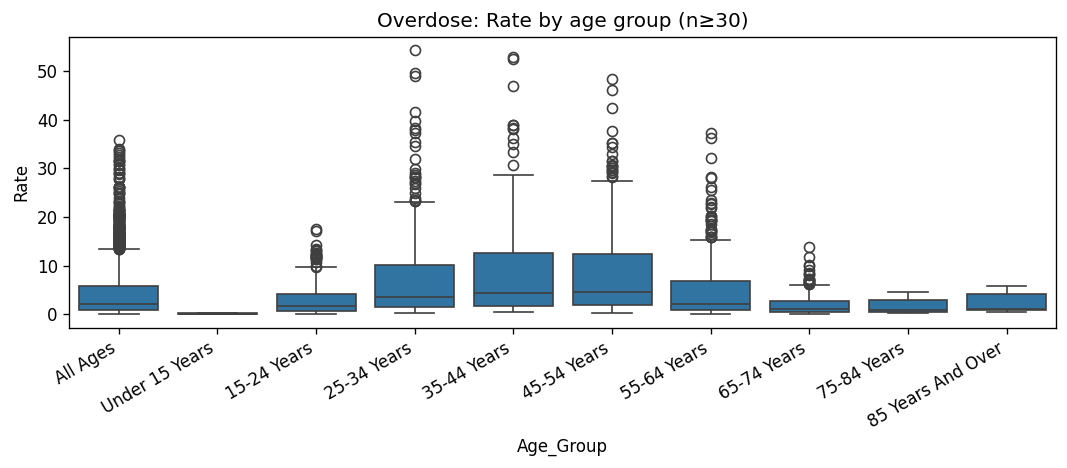

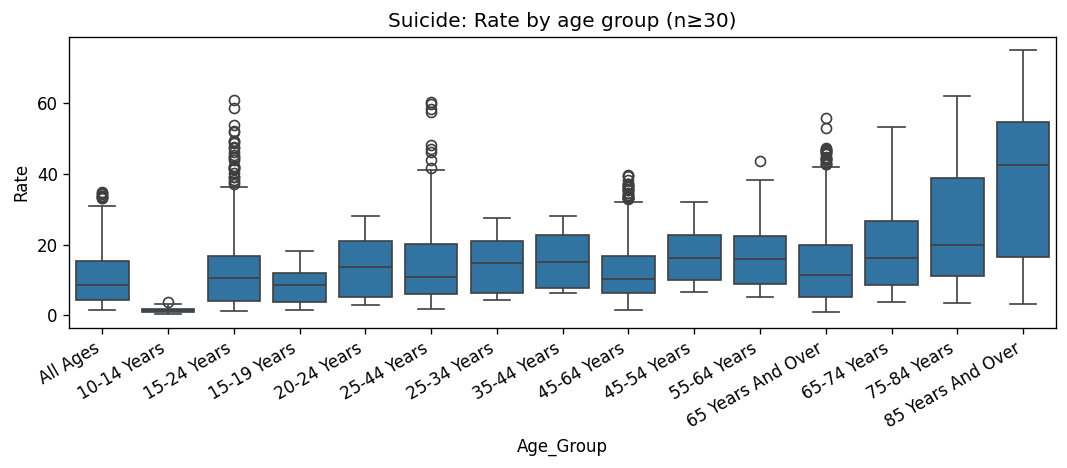

In [17]:
# ========= B) AGE GROUP COMPARISONS =========
import seaborn as sns
import pingouin as pg

def boxplot_by_age(df, title, fname_prefix, min_n=30):
    # keep age groups with enough rows
    counts = df["Age_Group"].value_counts()
    keep = counts[counts >= min_n].index
    sub = df[df["Age_Group"].isin(keep)]
    plt.figure(figsize=(9,4))
    sns.boxplot(data=sub, x="Age_Group", y="Rate")
    plt.xticks(rotation=30, ha="right")
    plt.title(f"{title}: Rate by age group (n≥{min_n})")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/{fname_prefix}_box_age.png", dpi=300)

    if sub["Age_Group"].nunique() >= 2:
        aov = pg.anova(dv="Rate", between="Age_Group", data=sub).round(4)
        aov.to_csv(f"{TAB_DIR}/{fname_prefix}_anova_age.csv", index=False)
        display(aov)

boxplot_by_age(od_clean, "Overdose", "od")
boxplot_by_age(sd_clean, "Suicide",  "su")



Overdose — OLS Rate ~ Year

                            OLS Regression Results                            
Dep. Variable:                   Rate   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     438.3
Date:                Sat, 16 Aug 2025   Prob (F-statistic):           1.87e-93
Time:                        06:50:38   Log-Likelihood:                -16568.
No. Observations:                5117   AIC:                         3.314e+04
Df Residuals:                    5115   BIC:                         3.315e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -623.3329  

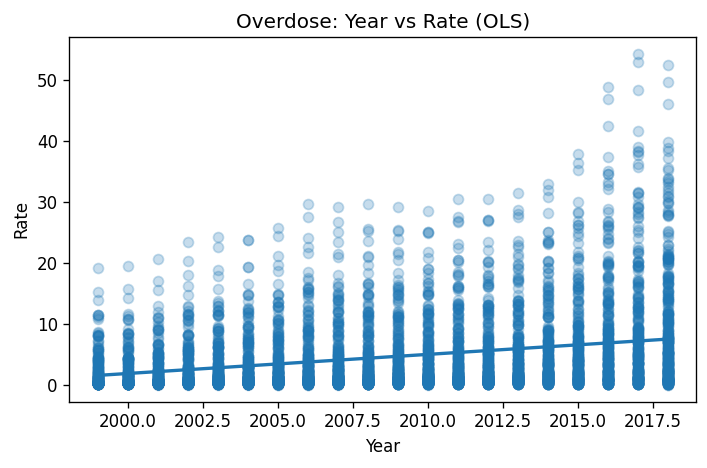

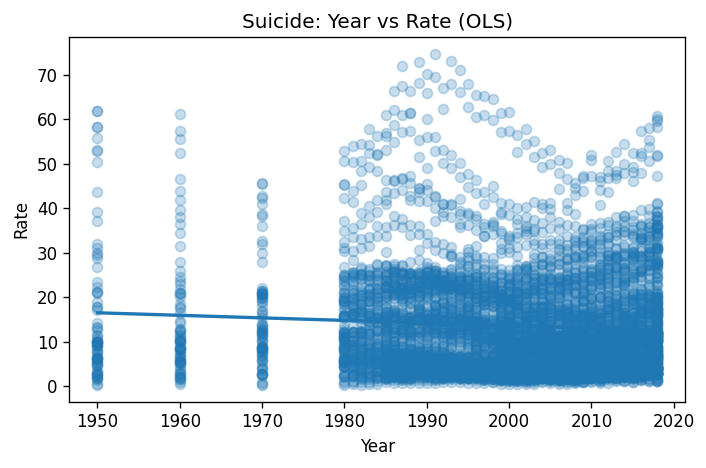

In [18]:
# ========= C) REGRESSION =========
import statsmodels.api as sm
import statsmodels.formula.api as smf

def reg_year(df, title, fname_prefix):
    t = df.dropna(subset=["Year","Rate"]).copy()
    X = sm.add_constant(t["Year"].astype(float))
    y = t["Rate"].astype(float)
    model = sm.OLS(y, X).fit()
    print(f"\n{title} — OLS Rate ~ Year\n")
    print(model.summary())

    # plot with line
    plt.figure(figsize=(6,4))
    plt.scatter(t["Year"], t["Rate"], alpha=0.25)
    xs = np.linspace(t["Year"].min(), t["Year"].max(), 50)
    ys = model.params["const"] + model.params["Year"]*xs
    plt.plot(xs, ys, lw=2)
    plt.title(f"{title}: Year vs Rate (OLS)")
    plt.xlabel("Year"); plt.ylabel("Rate")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/{fname_prefix}_ols_year.png", dpi=300)

def reg_with_age_interaction(df, title, fname_prefix):
    # GLM: Rate ~ Year + C(Age_Group) + Year*C(Age_Group)
    t = df.dropna(subset=["Year","Rate","Age_Group"]).copy()
    formula = "Rate ~ Year + C(Age_Group) + Year:C(Age_Group)"
    model = smf.glm(formula=formula, data=t, family=sm.families.Gaussian()).fit()
    print(f"\n{title} — GLM {formula}\n")
    print(model.summary())
    coef = model.summary2().tables[1]
    coef.to_csv(f"{TAB_DIR}/{fname_prefix}_glm_age_interaction.csv")

reg_year(od_clean, "Overdose", "od")
reg_year(sd_clean, "Suicide",  "su")
reg_with_age_interaction(od_clean, "Overdose", "od")
reg_with_age_interaction(sd_clean, "Suicide",  "su")


,Year,Overdose,Suicide,OD_to_SU_Ratio
0,1999,2.305714,11.850327,0.194570
1,2000,2.300939,11.706579,0.196551
2,2001,2.433333,11.809211,0.206054
3,2002,2.864957,11.941447,0.239917
4,2003,3.125214,11.606494,0.269264
5,2004,3.276987,12.204575,0.268505
6,2005,3.459514,11.775484,0.293790
7,2006,3.957831,11.886275,0.332975
8,2007,4.063200,12.061184,0.336882
9,2008,4.064615,12.012102,0.338377


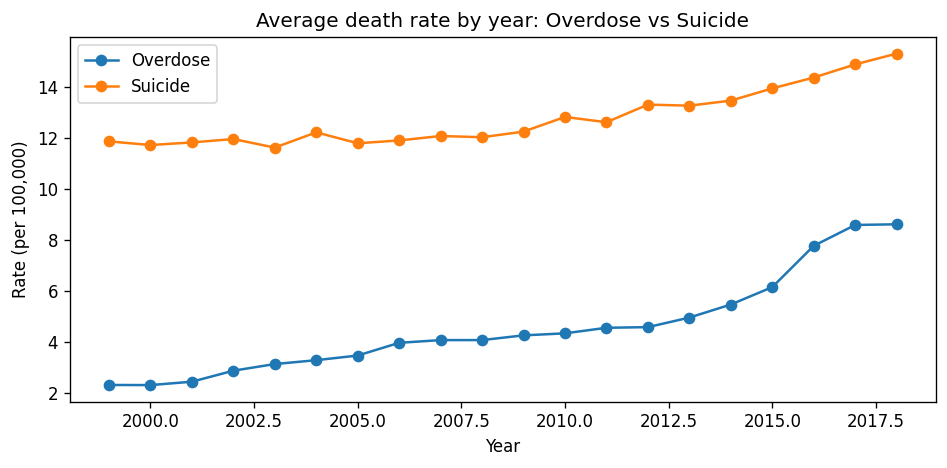

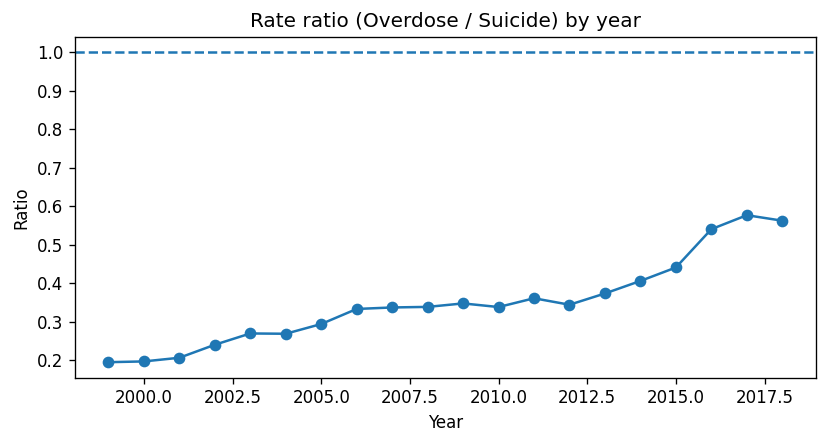

In [19]:
# ========= D) DATASET COMPARISON =========
def compare_yearly(od_df, su_df):
    a = od_df.groupby("Year")["Rate"].mean().rename("Overdose").reset_index()
    b = su_df.groupby("Year")["Rate"].mean().rename("Suicide").reset_index()
    m = pd.merge(a, b, on="Year", how="inner").sort_values("Year")
    m["OD_to_SU_Ratio"] = m["Overdose"] / m["Suicide"]

    # plot both series
    plt.figure(figsize=(8,4))
    plt.plot(m["Year"], m["Overdose"], marker="o", label="Overdose")
    plt.plot(m["Year"], m["Suicide"],  marker="o", label="Suicide")
    plt.title("Average death rate by year: Overdose vs Suicide")
    plt.xlabel("Year"); plt.ylabel("Rate (per 100,000)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/compare_overdose_vs_suicide.png", dpi=300)

    # plot ratio
    plt.figure(figsize=(7,3.8))
    plt.plot(m["Year"], m["OD_to_SU_Ratio"], marker="o")
    plt.axhline(1.0, ls="--")
    plt.title("Rate ratio (Overdose / Suicide) by year")
    plt.xlabel("Year"); plt.ylabel("Ratio")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/compare_ratio.png", dpi=300)

    m.to_csv(f"{TAB_DIR}/compare_yearly_overdose_suicide.csv", index=False)
    return m

compare_yearly(od_clean, sd_clean)


In [20]:
# ========= E) TOP FINDINGS TABLES =========
def top_by_age(df, name, n=10):
    t = (df.groupby("Age_Group")["Rate"]
           .mean().reset_index()
           .sort_values("Rate", ascending=False)
           .head(n))
    t.to_csv(f"{TAB_DIR}/{name}_top_age_groups.csv", index=False)
    return t

display(top_by_age(od_clean, "od"))
display(top_by_age(sd_clean, "su"))


,Age_Group,Rate
3,45-54 Years,8.617222
2,35-44 Years,8.462778
1,25-34 Years,7.459722
4,55-64 Years,5.116571
8,All Ages,4.423863
0,15-24 Years,3.066761
7,85 Years And Over,2.423485
5,65-74 Years,1.937370
6,75-84 Years,1.507650
9,Under 15 Years,0.129677


,Age_Group,Rate
13,85 Years And Over,34.504734
12,75-84 Years,25.565550
11,65-74 Years,18.478774
7,45-54 Years,17.075397
9,55-64 Years,16.578571
6,35-44 Years,15.565873
10,65 Years And Over,15.073322
4,25-34 Years,14.323810
3,20-24 Years,13.757937
5,25-44 Years,13.647194


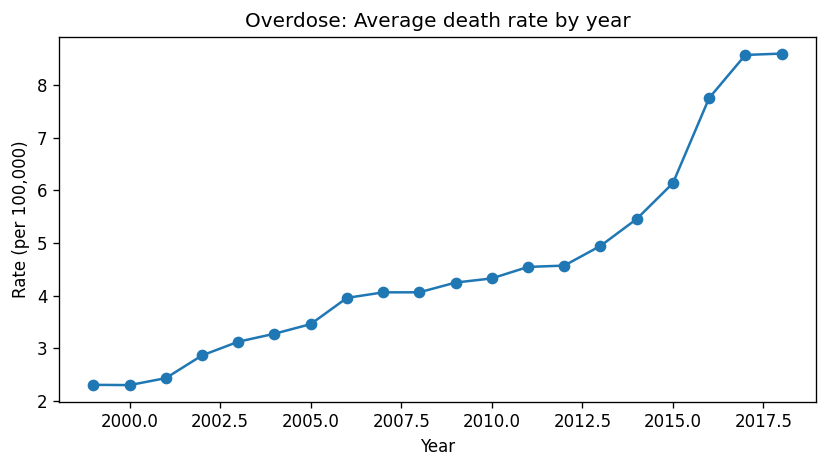

Saved figure -> figures/A1_overdose_trend_overall.png
Saved data   -> tables/A1_overdose_trend_overall.csv


In [21]:
# Figure A1 – Overdose: Average death rate by year (overall trend)

import os
import pandas as pd
import matplotlib.pyplot as plt

# ensure output folders
FIG_DIR, TAB_DIR = "figures", "tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

# aggregate yearly mean rate
a1 = (od_clean
      .dropna(subset=["Year", "Rate"])
      .groupby("Year", dropna=True)["Rate"]
      .mean()
      .reset_index()
      .sort_values("Year"))

# plot
plt.figure(figsize=(7,4))
plt.plot(a1["Year"], a1["Rate"], marker="o")
plt.title("Overdose: Average death rate by year")
plt.xlabel("Year")
plt.ylabel("Rate (per 100,000)")
plt.tight_layout()

# save
fig_path = f"{FIG_DIR}/A1_overdose_trend_overall.png"
csv_path = f"{TAB_DIR}/A1_overdose_trend_overall.csv"
plt.savefig(fig_path, dpi=300)
plt.show()

# also save the data used for the figure
a1.to_csv(csv_path, index=False)

print(f"Saved figure -> {fig_path}")
print(f"Saved data   -> {csv_path}")


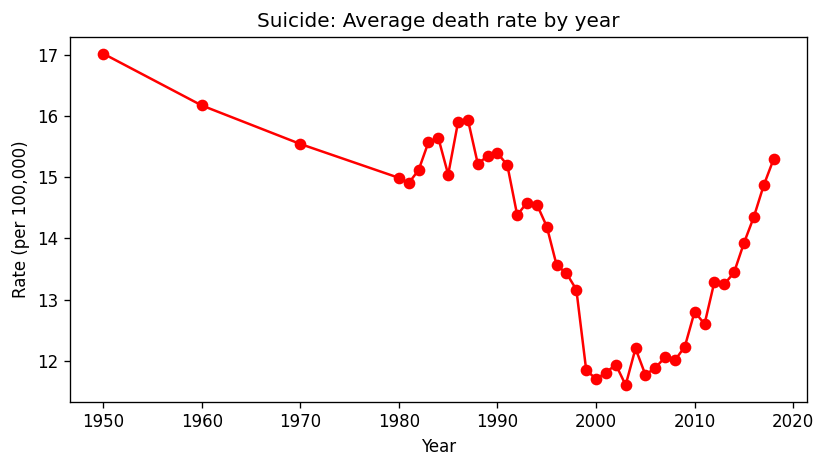

Saved figure -> figures/A2_suicide_trend_overall.png
Saved data   -> tables/A2_suicide_trend_overall.csv


In [22]:
# Figure A2 – Suicide: Average death rate by year (overall trend)

import os
import pandas as pd
import matplotlib.pyplot as plt

# ensure output folders exist
FIG_DIR, TAB_DIR = "figures", "tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

# aggregate yearly mean rate
a2 = (sd_clean
      .dropna(subset=["Year", "Rate"])
      .groupby("Year", dropna=True)["Rate"]
      .mean()
      .reset_index()
      .sort_values("Year"))

# plot
plt.figure(figsize=(7,4))
plt.plot(a2["Year"], a2["Rate"], marker="o", color="red")
plt.title("Suicide: Average death rate by year")
plt.xlabel("Year")
plt.ylabel("Rate (per 100,000)")
plt.tight_layout()

# save
fig_path = f"{FIG_DIR}/A2_suicide_trend_overall.png"
csv_path = f"{TAB_DIR}/A2_suicide_trend_overall.csv"
plt.savefig(fig_path, dpi=300)
plt.show()

# also save the underlying data
a2.to_csv(csv_path, index=False)

print(f"Saved figure -> {fig_path}")
print(f"Saved data   -> {csv_path}")


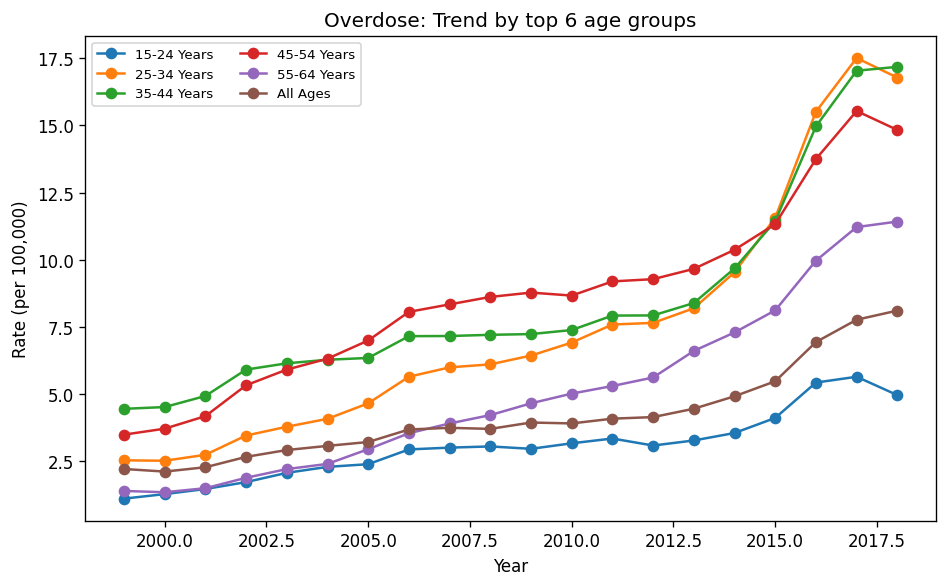

Saved figure -> figures/A3_overdose_trend_top6_age.png
Saved data   -> tables/A3_overdose_trend_top6_age.csv


In [23]:
# Figure A3 – Overdose: Trend by top 6 age groups

import os
import pandas as pd
import matplotlib.pyplot as plt

# ensure output folders
FIG_DIR, TAB_DIR = "figures", "tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

# pick top 6 age groups (highest mean rate across all years)
top_ages = (od_clean.groupby("Age_Group")["Rate"]
              .mean()
              .sort_values(ascending=False)
              .head(6)
              .index.tolist())

# filter to only top age groups
sub = od_clean[od_clean["Age_Group"].isin(top_ages)].copy()

# aggregate yearly average per age group
a3 = (sub.groupby(["Year","Age_Group"])["Rate"]
          .mean()
          .reset_index()
          .sort_values("Year"))

# plot
plt.figure(figsize=(8,5))
for age, d in a3.groupby("Age_Group"):
    plt.plot(d["Year"], d["Rate"], marker="o", label=age)

plt.title("Overdose: Trend by top 6 age groups")
plt.xlabel("Year")
plt.ylabel("Rate (per 100,000)")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()

# save
fig_path = f"{FIG_DIR}/A3_overdose_trend_top6_age.png"
csv_path = f"{TAB_DIR}/A3_overdose_trend_top6_age.csv"
plt.savefig(fig_path, dpi=300)
plt.show()

# save the underlying data
a3.to_csv(csv_path, index=False)

print(f"Saved figure -> {fig_path}")
print(f"Saved data   -> {csv_path}")


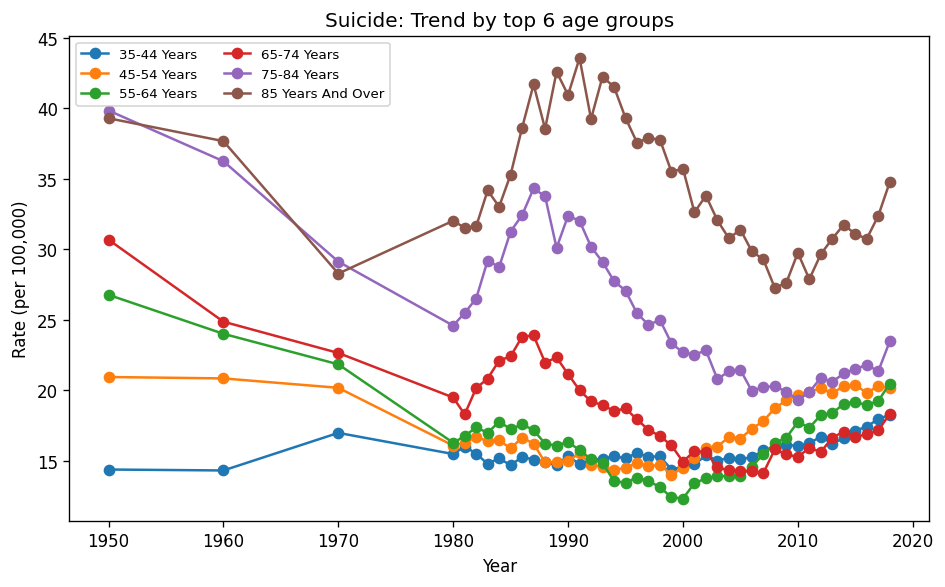

Saved figure -> figures/A4_suicide_trend_top6_age.png
Saved data   -> tables/A4_suicide_trend_top6_age.csv


In [24]:
# Figure A4 – Suicide: Trend by top 6 age groups

import os
import pandas as pd
import matplotlib.pyplot as plt

# ensure output folders
FIG_DIR, TAB_DIR = "figures", "tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

# pick top 6 age groups (highest mean rate across all years)
top_ages_su = (sd_clean.groupby("Age_Group")["Rate"]
                 .mean()
                 .sort_values(ascending=False)
                 .head(6)
                 .index.tolist())

# filter to only top age groups
sub_su = sd_clean[sd_clean["Age_Group"].isin(top_ages_su)].copy()

# aggregate yearly average per age group
a4 = (sub_su.groupby(["Year","Age_Group"])["Rate"]
            .mean()
            .reset_index()
            .sort_values("Year"))

# plot
plt.figure(figsize=(8,5))
for age, d in a4.groupby("Age_Group"):
    plt.plot(d["Year"], d["Rate"], marker="o", label=age)

plt.title("Suicide: Trend by top 6 age groups")
plt.xlabel("Year")
plt.ylabel("Rate (per 100,000)")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()

# save
fig_path = f"{FIG_DIR}/A4_suicide_trend_top6_age.png"
csv_path = f"{TAB_DIR}/A4_suicide_trend_top6_age.csv"
plt.savefig(fig_path, dpi=300)
plt.show()

# save the underlying data
a4.to_csv(csv_path, index=False)

print(f"Saved figure -> {fig_path}")
print(f"Saved data   -> {csv_path}")


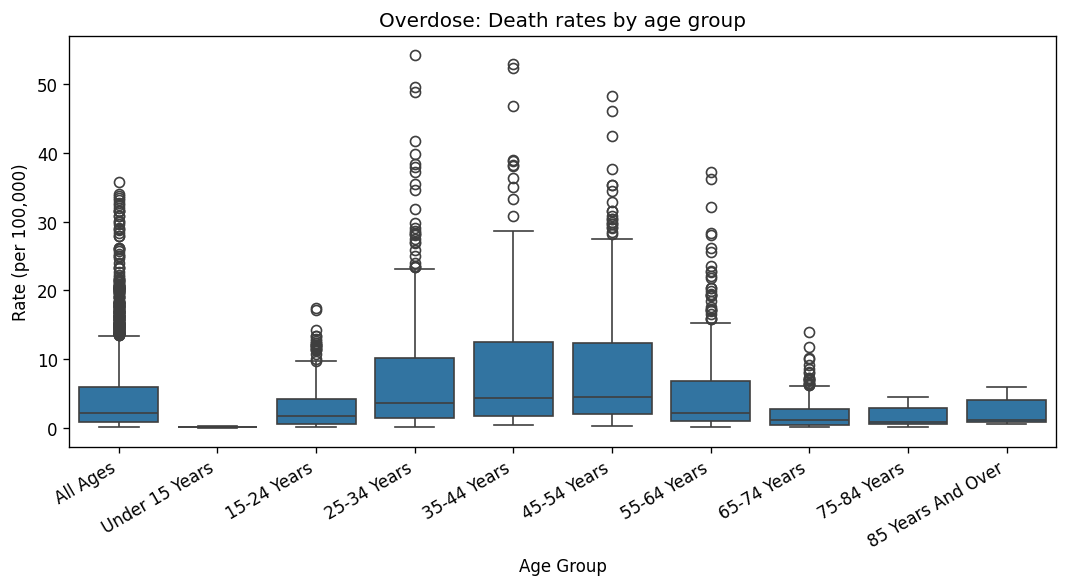

Saved figure -> figures/A5_overdose_box_age.png
Saved data   -> tables/A5_overdose_box_age.csv


In [25]:
# Figure A5 – Overdose: Boxplot of death rates by age group

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ensure output folders
FIG_DIR, TAB_DIR = "figures", "tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

# keep only age groups with enough rows (≥30 obs)
counts = od_clean["Age_Group"].value_counts()
keep = counts[counts >= 30].index
sub_od = od_clean[od_clean["Age_Group"].isin(keep)].copy()

# plot
plt.figure(figsize=(9,5))
sns.boxplot(data=sub_od, x="Age_Group", y="Rate")
plt.xticks(rotation=30, ha="right")
plt.title("Overdose: Death rates by age group")
plt.ylabel("Rate (per 100,000)")
plt.xlabel("Age Group")
plt.tight_layout()

# save
fig_path = f"{FIG_DIR}/A5_overdose_box_age.png"
csv_path = f"{TAB_DIR}/A5_overdose_box_age.csv"
plt.savefig(fig_path, dpi=300)
plt.show()

# also export summary stats
summary_a5 = sub_od.groupby("Age_Group")["Rate"].describe().round(2).reset_index()
summary_a5.to_csv(csv_path, index=False)

print(f"Saved figure -> {fig_path}")
print(f"Saved data   -> {csv_path}")


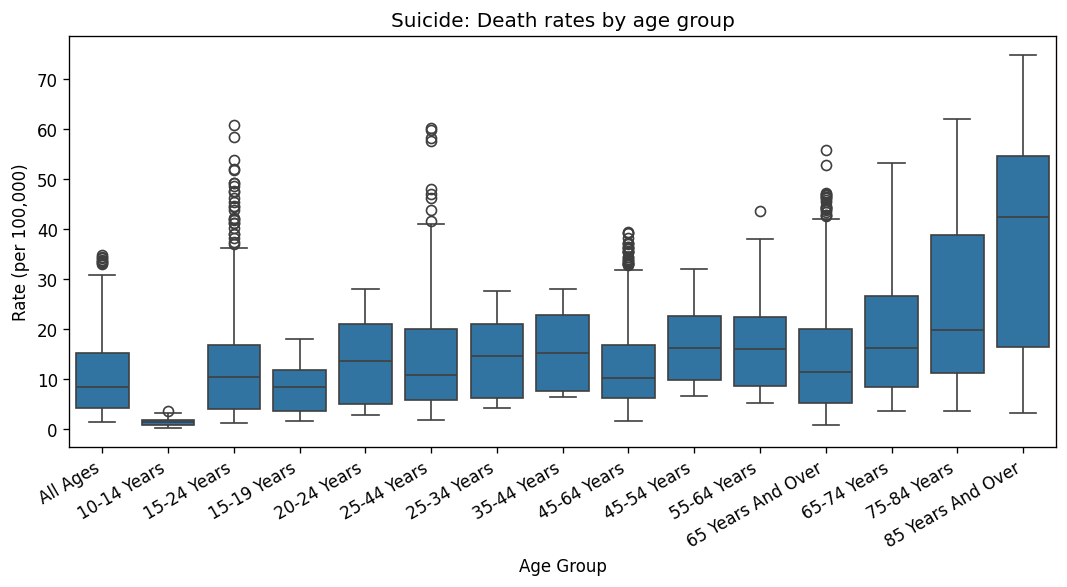

Saved figure -> figures/A6_suicide_box_age.png
Saved data   -> tables/A6_suicide_box_age.csv


In [26]:
# Figure A6 – Suicide: Boxplot of death rates by age group

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ensure output folders exist
FIG_DIR, TAB_DIR = "figures", "tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

# keep only age groups with enough rows (≥30 obs)
counts = sd_clean["Age_Group"].value_counts()
keep = counts[counts >= 30].index
sub_su = sd_clean[sd_clean["Age_Group"].isin(keep)].copy()

# plot
plt.figure(figsize=(9,5))
sns.boxplot(data=sub_su, x="Age_Group", y="Rate")
plt.xticks(rotation=30, ha="right")
plt.title("Suicide: Death rates by age group")
plt.ylabel("Rate (per 100,000)")
plt.xlabel("Age Group")
plt.tight_layout()

# save
fig_path = f"{FIG_DIR}/A6_suicide_box_age.png"
csv_path = f"{TAB_DIR}/A6_suicide_box_age.csv"
plt.savefig(fig_path, dpi=300)
plt.show()

# also export summary stats
summary_a6 = sub_su.groupby("Age_Group")["Rate"].describe().round(2).reset_index()
summary_a6.to_csv(csv_path, index=False)

print(f"Saved figure -> {fig_path}")
print(f"Saved data   -> {csv_path}")


In [29]:
# Figure A7 – Overdose: Regression of Rate ~ Year

import os
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# ensure output folders exist
FIG_DIR, TAB_DIR = "figures", "tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

# drop missing and prepare data
t = od_clean.dropna(subset=["Year","Rate"]).copy()
X = sm.add_constant(t["Year"].astype(float))
y = t["Rate"].astype(float)

# fit OLS model
model = sm.OLS(y, X).fit()

# print summary to



Overdose — OLS Regression: Rate ~ Year

                            OLS Regression Results                            
Dep. Variable:                   Rate   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     438.3
Date:                Sat, 16 Aug 2025   Prob (F-statistic):           1.87e-93
Time:                        07:04:42   Log-Likelihood:                -16568.
No. Observations:                5117   AIC:                         3.314e+04
Df Residuals:                    5115   BIC:                         3.315e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

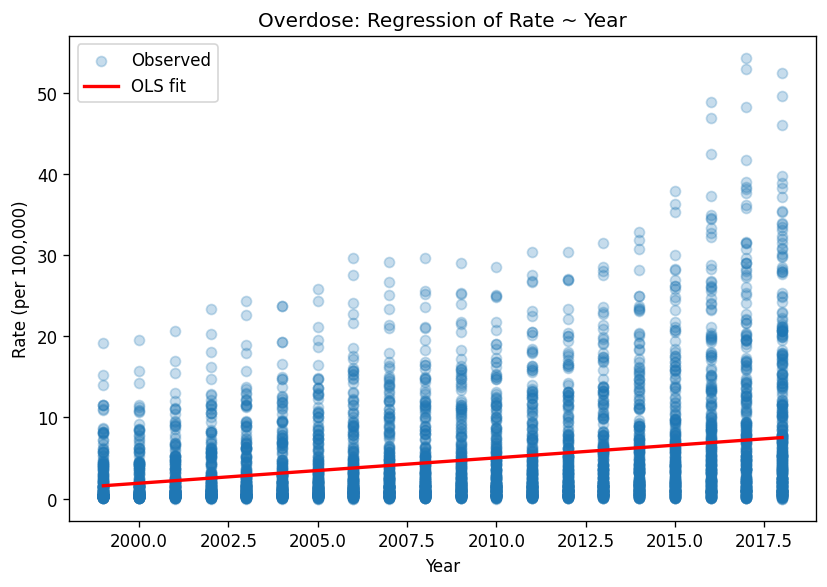

Saved figure -> figures/A7_overdose_regression.png
Saved coeffs -> tables/A7_overdose_regression_coeffs.csv


In [30]:
# Figure A7 – Overdose: Regression of Rate ~ Year

import os
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# ensure output folders exist
FIG_DIR, TAB_DIR = "figures", "tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

# drop missing and prepare data
t = od_clean.dropna(subset=["Year","Rate"]).copy()
X = sm.add_constant(t["Year"].astype(float))
y = t["Rate"].astype(float)

# fit OLS model
model = sm.OLS(y, X).fit()

# print summary to console
print("\nOverdose — OLS Regression: Rate ~ Year\n")
print(model.summary())

# save coefficients to CSV
coef = model.summary2().tables[1]
coef.to_csv(f"{TAB_DIR}/A7_overdose_regression_coeffs.csv")

# plot scatter + regression line
plt.figure(figsize=(7,5))
plt.scatter(t["Year"], t["Rate"], alpha=0.25, label="Observed")
xs = np.linspace(t["Year"].min(), t["Year"].max(), 50)
ys = model.params["const"] + model.params["Year"]*xs
plt.plot(xs, ys, color="red", lw=2, label="OLS fit")
plt.title("Overdose: Regression of Rate ~ Year")
plt.xlabel("Year")
plt.ylabel("Rate (per 100,000)")
plt.legend()
plt.tight_layout()

# save figure
fig_path = f"{FIG_DIR}/A7_overdose_regression.png"
plt.savefig(fig_path, dpi=300)
plt.show()

print(f"Saved figure -> {fig_path}")
print(f"Saved coeffs -> {TAB_DIR}/A7_overdose_regression_coeffs.csv")



Suicide — OLS Regression: Rate ~ Year

                            OLS Regression Results                            
Dep. Variable:                   Rate   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     24.97
Date:                Sat, 16 Aug 2025   Prob (F-statistic):           6.02e-07
Time:                        07:05:22   Log-Likelihood:                -21177.
No. Observations:                5484   AIC:                         4.236e+04
Df Residuals:                    5482   BIC:                         4.237e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

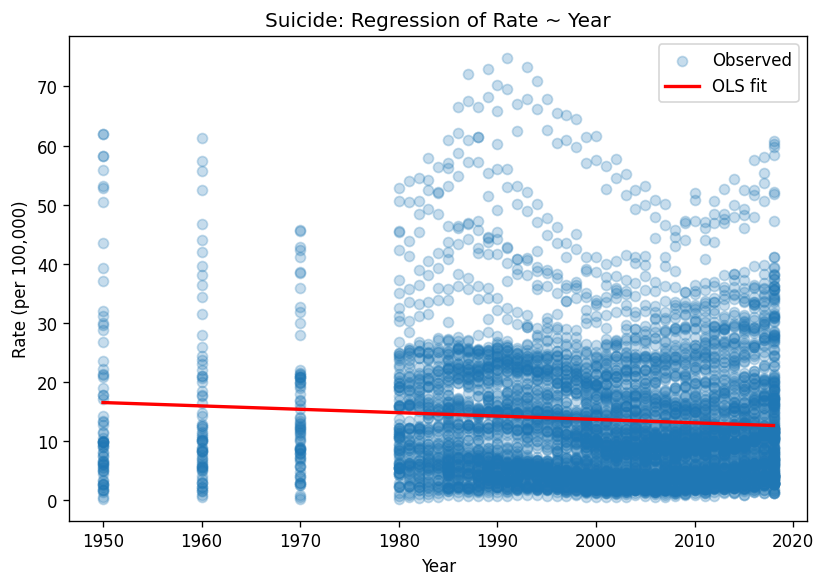

Saved figure -> figures/A8_suicide_regression.png
Saved coeffs -> tables/A8_suicide_regression_coeffs.csv


In [31]:
# Figure A8 – Suicide: Regression of Rate ~ Year

import os
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# ensure output folders exist
FIG_DIR, TAB_DIR = "figures", "tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

# drop missing and prepare data
t = sd_clean.dropna(subset=["Year","Rate"]).copy()
X = sm.add_constant(t["Year"].astype(float))
y = t["Rate"].astype(float)

# fit OLS model
model = sm.OLS(y, X).fit()

# print summary to console
print("\nSuicide — OLS Regression: Rate ~ Year\n")
print(model.summary())

# save coefficients to CSV
coef = model.summary2().tables[1]
coef.to_csv(f"{TAB_DIR}/A8_suicide_regression_coeffs.csv")

# plot scatter + regression line
plt.figure(figsize=(7,5))
plt.scatter(t["Year"], t["Rate"], alpha=0.25, label="Observed")
xs = np.linspace(t["Year"].min(), t["Year"].max(), 50)
ys = model.params["const"] + model.params["Year"]*xs
plt.plot(xs, ys, color="red", lw=2, label="OLS fit")
plt.title("Suicide: Regression of Rate ~ Year")
plt.xlabel("Year")
plt.ylabel("Rate (per 100,000)")
plt.legend()
plt.tight_layout()

# save figure
fig_path = f"{FIG_DIR}/A8_suicide_regression.png"
plt.savefig(fig_path, dpi=300)
plt.show()

print(f"Saved figure -> {fig_path}")
print(f"Saved coeffs -> {TAB_DIR}/A8_suicide_regression_coeffs.csv")



Overdose — GLM with Year × Age_Group interaction

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Rate   No. Observations:                 5117
Model:                            GLM   Df Residuals:                     5097
Model Family:                Gaussian   Df Model:                           19
Link Function:               Identity   Scale:                          32.142
Method:                          IRLS   Log-Likelihood:                -16129.
Date:                Sat, 16 Aug 2025   Deviance:                   1.6383e+05
Time:                        07:07:44   Pearson chi2:                 1.64e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2501
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

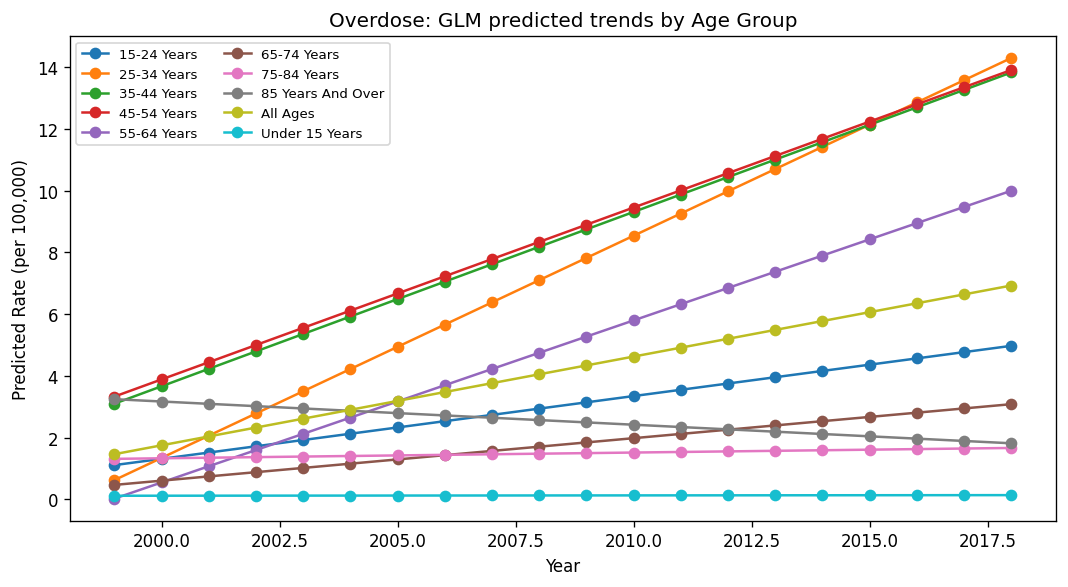

Saved figure -> figures/A9_overdose_glm_age_interaction.png
Saved coeffs -> tables/A9_overdose_glm_age_interaction_coeffs.csv


In [33]:
# Figure A9 – Overdose: GLM with Year × Age_Group interaction

import os
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm # Import statsmodels.api for families

# ensure output folders exist
FIG_DIR, TAB_DIR = "figures", "tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

# drop missing
t = od_clean.dropna(subset=["Year","Rate","Age_Group"]).copy()

# fit GLM: Rate ~ Year + Age_Group + interaction
formula = "Rate ~ Year + C(Age_Group) + Year:C(Age_Group)"
model = smf.glm(formula=formula, data=t, family=sm.families.Gaussian()).fit() # Corrected family access

print("\nOverdose — GLM with Year × Age_Group interaction\n")
print(model.summary())

# save coefficients table
coef = model.summary2().tables[1]
coef.to_csv(f"{TAB_DIR}/A9_overdose_glm_age_interaction_coeffs.csv")

# predicted trends for selected age groups
pred_df = t[["Year","Age_Group"]].drop_duplicates().copy()
pred_df["Rate_pred"] = model.predict(pred_df)

plt.figure(figsize=(9,5))
for age, d in pred_df.groupby("Age_Group"):
    plt.plot(d["Year"], d["Rate_pred"], marker="o", label=age)

plt.title("Overdose: GLM predicted trends by Age Group")
plt.xlabel("Year")
plt.ylabel("Predicted Rate (per 100,000)")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()

# save figure
fig_path = f"{FIG_DIR}/A9_overdose_glm_age_interaction.png"
plt.savefig(fig_path, dpi=300)
plt.show()

print(f"Saved figure -> {fig_path}")
print(f"Saved coeffs -> {TAB_DIR}/A9_overdose_glm_age_interaction_coeffs.csv")


Suicide — GLM with Year × Age_Group interaction

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Rate   No. Observations:                 5484
Model:                            GLM   Df Residuals:                     5454
Model Family:                Gaussian   Df Model:                           29
Link Function:               Identity   Scale:                          103.24
Method:                          IRLS   Log-Likelihood:                -20481.
Date:                Sat, 16 Aug 2025   Deviance:                   5.6306e+05
Time:                        07:09:28   Pearson chi2:                 5.63e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2542
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

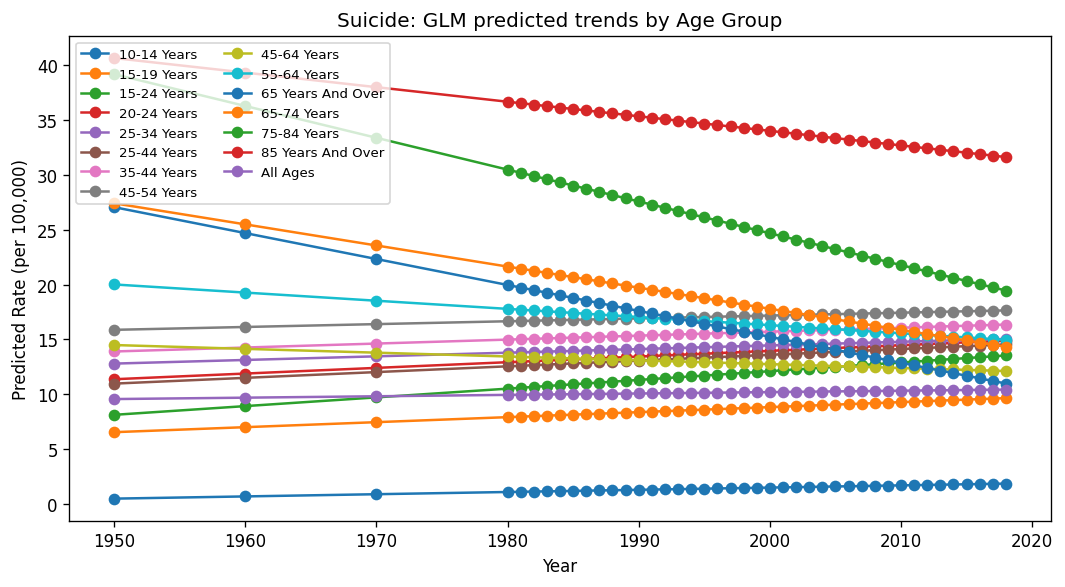

Saved figure -> figures/A10_suicide_glm_age_interaction.png
Saved coeffs -> tables/A10_suicide_glm_age_interaction_coeffs.csv


In [35]:
# Figure A10 – Suicide: GLM with Year × Age_Group interaction

import os
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm # Import statsmodels.api for families

# ensure output folders exist
FIG_DIR, TAB_DIR = "figures", "tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

# drop missing
t = sd_clean.dropna(subset=["Year","Rate","Age_Group"]).copy()

# fit GLM: Rate ~ Year + Age_Group + interaction
formula = "Rate ~ Year + C(Age_Group) + Year:C(Age_Group)"
model = smf.glm(formula=formula, data=t, family=sm.families.Gaussian()).fit()

print("\nSuicide — GLM with Year × Age_Group interaction\n")
print(model.summary())

# save coefficients table
coef = model.summary2().tables[1]
coef.to_csv(f"{TAB_DIR}/A10_suicide_glm_age_interaction_coeffs.csv")

# predicted trends for selected age groups
pred_df = t[["Year","Age_Group"]].drop_duplicates().copy()
pred_df["Rate_pred"] = model.predict(pred_df)

plt.figure(figsize=(9,5))
for age, d in pred_df.groupby("Age_Group"):
    plt.plot(d["Year"], d["Rate_pred"], marker="o", label=age)

plt.title("Suicide: GLM predicted trends by Age Group")
plt.xlabel("Year")
plt.ylabel("Predicted Rate (per 100,000)")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()

# save figure
fig_path = f"{FIG_DIR}/A10_suicide_glm_age_interaction.png"
plt.savefig(fig_path, dpi=300)
plt.show()

print(f"Saved figure -> {fig_path}")
print(f"Saved coeffs -> {TAB_DIR}/A10_suicide_glm_age_interaction_coeffs.csv")

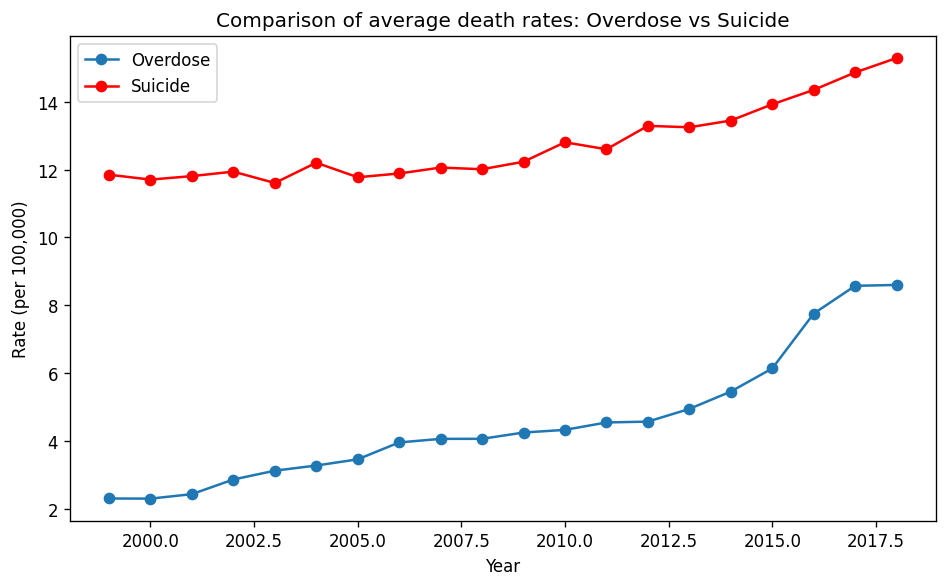

Saved figure -> figures/A11_compare_overdose_suicide.png
Saved data   -> tables/A11_compare_overdose_suicide.csv


In [36]:
# Figure A11 – Comparison plot: Overdose vs Suicide (average yearly rates)

import os
import pandas as pd
import matplotlib.pyplot as plt

# ensure output folders exist
FIG_DIR, TAB_DIR = "figures", "tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

# yearly averages for overdose
od_yearly = (od_clean.dropna(subset=["Year","Rate"])
             .groupby("Year")["Rate"]
             .mean()
             .reset_index()
             .rename(columns={"Rate":"Overdose"}))

# yearly averages for suicide
su_yearly = (sd_clean.dropna(subset=["Year","Rate"])
             .groupby("Year")["Rate"]
             .mean()
             .reset_index()
             .rename(columns={"Rate":"Suicide"}))

# merge datasets on Year
comp = pd.merge(od_yearly, su_yearly, on="Year", how="inner").sort_values("Year")

# plot both series
plt.figure(figsize=(8,5))
plt.plot(comp["Year"], comp["Overdose"], marker="o", label="Overdose")
plt.plot(comp["Year"], comp["Suicide"], marker="o", label="Suicide", color="red")
plt.title("Comparison of average death rates: Overdose vs Suicide")
plt.xlabel("Year")
plt.ylabel("Rate (per 100,000)")
plt.legend()
plt.tight_layout()

# save figure and data
fig_path = f"{FIG_DIR}/A11_compare_overdose_suicide.png"
csv_path = f"{TAB_DIR}/A11_compare_overdose_suicide.csv"
plt.savefig(fig_path, dpi=300)
plt.show()

# export underlying data
comp.to_csv(csv_path, index=False)

print(f"Saved figure -> {fig_path}")
print(f"Saved data   -> {csv_path}")


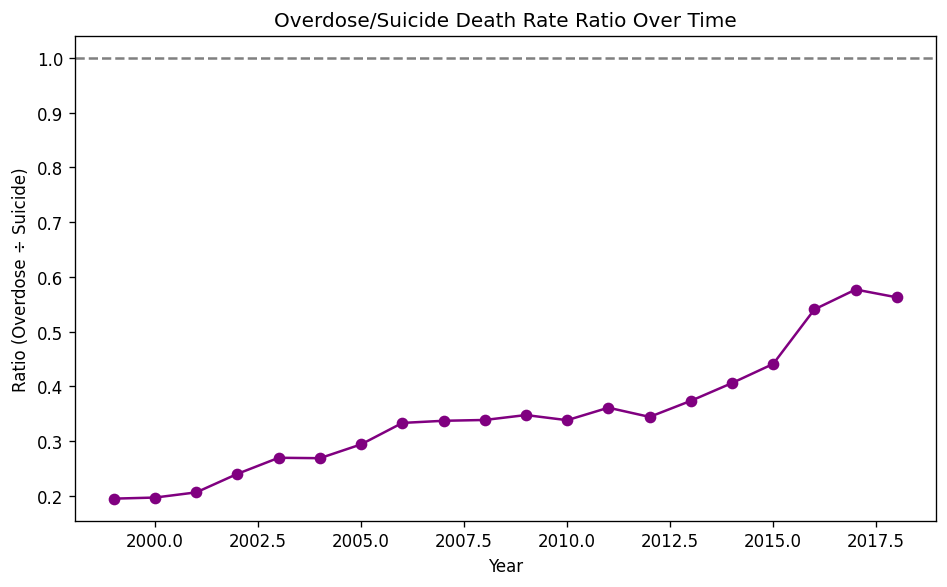

Saved figure -> figures/A12_overdose_suicide_ratio.png
Saved data   -> tables/A12_overdose_suicide_ratio.csv


In [37]:
# Figure A12 – Comparison plot: Ratio Overdose / Suicide over time

import os
import pandas as pd
import matplotlib.pyplot as plt

# ensure output folders exist
FIG_DIR, TAB_DIR = "figures", "tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

# yearly averages for overdose
od_yearly = (od_clean.dropna(subset=["Year","Rate"])
             .groupby("Year")["Rate"]
             .mean()
             .reset_index()
             .rename(columns={"Rate":"Overdose"}))

# yearly averages for suicide
su_yearly = (sd_clean.dropna(subset=["Year","Rate"])
             .groupby("Year")["Rate"]
             .mean()
             .reset_index()
             .rename(columns={"Rate":"Suicide"}))

# merge datasets
comp = pd.merge(od_yearly, su_yearly, on="Year", how="inner").sort_values("Year")

# calculate ratio
comp["OD_to_SU_Ratio"] = comp["Overdose"] / comp["Suicide"]

# plot ratio
plt.figure(figsize=(8,5))
plt.plot(comp["Year"], comp["OD_to_SU_Ratio"], marker="o", color="purple")
plt.axhline(1.0, ls="--", color="gray")
plt.title("Overdose/Suicide Death Rate Ratio Over Time")
plt.xlabel("Year")
plt.ylabel("Ratio (Overdose ÷ Suicide)")
plt.tight_layout()

# save figure and data
fig_path = f"{FIG_DIR}/A12_overdose_suicide_ratio.png"
csv_path = f"{TAB_DIR}/A12_overdose_suicide_ratio.csv"
plt.savefig(fig_path, dpi=300)
plt.show()

# export underlying data
comp.to_csv(csv_path, index=False)

print(f"Saved figure -> {fig_path}")
print(f"Saved data   -> {csv_path}")


In [38]:
# Table A1 – Overdose: Trend by year (CSV extract)

import os
import pandas as pd

# ensure output folders exist
TAB_DIR = "tables"
os.makedirs(TAB_DIR, exist_ok=True)

# aggregate: average overdose rate by year
table_a1 = (od_clean.dropna(subset=["Year","Rate"])
            .groupby("Year")["Rate"]
            .mean()
            .reset_index()
            .sort_values("Year"))

# save to CSV
csv_path = f"{TAB_DIR}/A1_overdose_trend_by_year.csv"
table_a1.to_csv(csv_path, index=False)

# show first rows for confirmation
display(table_a1.head(10))

print(f"Saved table -> {csv_path}")


,Year,Rate
0,1999,2.305714
1,2000,2.300939
2,2001,2.433333
3,2002,2.864957
4,2003,3.125214
5,2004,3.276987
6,2005,3.459514
7,2006,3.957831
8,2007,4.063200
9,2008,4.064615


Saved table -> tables/A1_overdose_trend_by_year.csv


In [39]:
# Table A2 – Suicide: Trend by year (CSV extract)

# aggregate: average suicide rate by year
table_a2 = (sd_clean.dropna(subset=["Year","Rate"])
            .groupby("Year")["Rate"]
            .mean()
            .reset_index()
            .sort_values("Year"))

# save to CSV
csv_path = f"{TAB_DIR}/A2_suicide_trend_by_year.csv"
table_a2.to_csv(csv_path, index=False)

# show first rows for confirmation
display(table_a2.head(10))

print(f"Saved table -> {csv_path}")


,Year,Rate
0,1950,17.017568
1,1960,16.171233
2,1970,15.542105
3,1980,14.989247
4,1981,14.904938
5,1982,15.116049
6,1983,15.571250
7,1984,15.640741
8,1985,15.042373
9,1986,15.898077


Saved table -> tables/A2_suicide_trend_by_year.csv


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Year'].plot(kind='hist', bins=20, title='Year')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Rate'].plot(kind='hist', bins=20, title='Rate')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='Year', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Year', y='Rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Rate']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Rate')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['Rate']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('Rate')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Year'}, axis=1)
              .sort_values('Year', ascending=True))
  xs = counted['Year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Year'].plot(kind='line', figsize=(8, 4), title='Year')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Rate'].plot(kind='line', figsize=(8, 4), title='Rate')
plt.gca().spines[['top', 'right']].set_visible(False)

In [40]:
from google.colab import files

# Download Table A1
files.download("tables/A1_overdose_trend_by_year.csv")

# Download Table A2
files.download("tables/A2_suicide_trend_by_year.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
# Suicide: Average trend by year
table_a2 = (
    sd_clean.groupby("Year")["Rate"]
    .mean()
    .reset_index()
    .sort_values("Year")
)

# Save to CSV
csv_path = f"{TAB_DIR}/A2_suicide_trend_by_year.csv"
table_a2.to_csv(csv_path, index=False)

# Show first rows for confirmation
display(table_a2.head(10))

print(f"Saved table -> {csv_path}")

from google.colab import files

# Download Table A1
files.download("tables/A1_overdose_trend_by_year.csv")

# Download Table A2
files.download("tables/A2_suicide_trend_by_year.csv")


,Year,Rate
0,1950,17.017568
1,1960,16.171233
2,1970,15.542105
3,1980,14.989247
4,1981,14.904938
5,1982,15.116049
6,1983,15.571250
7,1984,15.640741
8,1985,15.042373
9,1986,15.898077


Saved table -> tables/A2_suicide_trend_by_year.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
# Overdose: Average trend by age group
table_a3 = (
    od_clean.groupby("Age_Group")["Rate"]
    .mean()
    .reset_index()
    .sort_values("Rate", ascending=False)
)

# Save to CSV
csv_path = f"{TAB_DIR}/A3_overdose_trend_by_agegroup.csv"
table_a3.to_csv(csv_path, index=False)

# Show first rows for confirmation
display(table_a3.head(10))

print(f"Saved table -> {csv_path}")


,Age_Group,Rate
3,45-54 Years,8.617222
2,35-44 Years,8.462778
1,25-34 Years,7.459722
4,55-64 Years,5.116571
8,All Ages,4.423863
0,15-24 Years,3.066761
7,85 Years And Over,2.423485
5,65-74 Years,1.937370
6,75-84 Years,1.507650
9,Under 15 Years,0.129677


Saved table -> tables/A3_overdose_trend_by_agegroup.csv


In [43]:
# Suicide: Average trend by age group
table_a4 = (
    sd_clean.groupby("Age_Group")["Rate"]
    .mean()
    .reset_index()
    .sort_values("Rate", ascending=False)
)

# Save to CSV
csv_path = f"{TAB_DIR}/A4_suicide_trend_by_agegroup.csv"
table_a4.to_csv(csv_path, index=False)

# Show first rows for confirmation
display(table_a4.head(10))

print(f"Saved table -> {csv_path}")


,Age_Group,Rate
13,85 Years And Over,34.504734
12,75-84 Years,25.565550
11,65-74 Years,18.478774
7,45-54 Years,17.075397
9,55-64 Years,16.578571
6,35-44 Years,15.565873
10,65 Years And Over,15.073322
4,25-34 Years,14.323810
3,20-24 Years,13.757937
5,25-44 Years,13.647194


Saved table -> tables/A4_suicide_trend_by_agegroup.csv


In [44]:
# Appendix B builder: creates a .docx with your workshop screenshots
!pip -q install python-docx==1.1.2

import os, re, datetime as dt
from google.colab import files
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 4.4 MB/s eta 0:00:00


In [46]:
# Appendix B1 – Reflection for Unit 2 Workshop
reflection_text = """Appendix B1 – Reflection for Unit 2 Workshop
In Unit 2, I discussed the importance of using reliable public datasets,
highlighting the potential biases in mortality data reporting.
"""

# ---- Option 1: Save as TXT ----
with open("Appendix_B1.txt", "w") as f:
    f.write(reflection_text)

print("Reflection saved as Appendix_B1.txt")

# ---- Option 2: Save as CSV (good if you add B2, B3, etc.) ----
import pandas as pd

df = pd.DataFrame({
    "Appendix": ["B1"],
    "Unit": ["Unit 2 Workshop"],
    "Reflection": ["""In Unit 2, I discussed the importance of using reliable public datasets,
highlighting the potential biases in mortality data reporting."""]
})

df.to_csv("Appendix_B1.csv", index=False)
print("Reflection saved as Appendix_B1.csv")

# ---- Option 3: Save as DOCX ----
from docx import Document

doc = Document()
doc.add_heading("Appendix B1 – Reflection for Unit 2 Workshop", level=1)
doc.add_paragraph("In Unit 2, I discussed the importance of using reliable public datasets, "
                  "highlighting the potential biases in mortality data reporting.")
doc.save("Appendix_B1.docx")
print("Reflection saved as Appendix_B1.docx")


Reflection saved as Appendix_B1.txt
Reflection saved as Appendix_B1.csv
Reflection saved as Appendix_B1.docx


In [48]:
# Overdose: Yearly breakdown
overdose_yearly = od_clean.groupby("Year")["Rate"].mean().reset_index()
overdose_yearly.to_csv("Appendix_C1_Overdose_Yearly.csv", index=False)
overdose_yearly

,Year,Rate
0,1999,2.305714
1,2000,2.300939
2,2001,2.433333
3,2002,2.864957
4,2003,3.125214
5,2004,3.276987
6,2005,3.459514
7,2006,3.957831
8,2007,4.063200
9,2008,4.064615


In [50]:
# Suicide: Yearly breakdown
suicide_yearly = sd_clean.groupby("Year")["Rate"].mean().reset_index()
suicide_yearly.to_csv("Appendix_C2_Suicide_Yearly.csv", index=False)
suicide_yearly

,Year,Rate
0,1950,17.017568
1,1960,16.171233
2,1970,15.542105
3,1980,14.989247
4,1981,14.904938
5,1982,15.116049
6,1983,15.571250
7,1984,15.640741
8,1985,15.042373
9,1986,15.898077


In [52]:
# Supplementary descriptive statistics for both datasets
overdose_stats = od_clean["Rate"].describe()
suicide_stats = sd_clean["Rate"].describe()

print("Overdose Descriptive Statistics:\n", overdose_stats)
print("\nSuicide Descriptive Statistics:\n", suicide_stats)

Overdose Descriptive Statistics:
 count    5117.000000
mean        4.743443
std         6.424471
min         0.000000
25%         0.800000
50%         2.100000
75%         6.000000
max        54.300000
Name: Rate, dtype: float64

Suicide Descriptive Statistics:
 count    5484.000000
mean       13.709810
std        11.531805
min         0.300000
25%         5.000000
50%        10.500000
75%        19.500000
max        74.800000
Name: Rate, dtype: float64


In [54]:
# Supplementary descriptive statistics for both datasets
overdose_stats = od_clean["Rate"].describe()
suicide_stats = sd_clean["Rate"].describe()

print("Overdose Descriptive Statistics:\n", overdose_stats)
print("\nSuicide Descriptive Statistics:\n", suicide_stats)

Overdose Descriptive Statistics:
 count    5117.000000
mean        4.743443
std         6.424471
min         0.000000
25%         0.800000
50%         2.100000
75%         6.000000
max        54.300000
Name: Rate, dtype: float64

Suicide Descriptive Statistics:
 count    5484.000000
mean       13.709810
std        11.531805
min         0.300000
25%         5.000000
50%        10.500000
75%        19.500000
max        74.800000
Name: Rate, dtype: float64
